In [1]:
# import things
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import helper

In [2]:
# Define transform function
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5, 0.5))])

# Download and load the training set
trainingset = datasets.FashionMNIST('F_MNIST_data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainingset, shuffle=True, batch_size=64)

# Download and load test set
testset = datasets.FashionMNIST('F_MNIST_data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=64)

## Building the Network

__Goal__: Build a network with an arbitrary number of hidden layers and their number of nodes.

To be able to do that, we can use `nn.ModuleList`. It allows us to define arbitrary number of hidden layers having arbitrary number of nodes. Further, this module can be extended to take `nn.Linear` with appropriate sizes for its input and output layers

We, then, will build a class formed as subclass of `nn.Module` container.

In [3]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds feedforward neural network with arbitrary hidden layers.
        
        parameters
        ----------
        input_size: int, size of the input
        output_size: int, size of the output layer
        hidden_layer: list of int, the sizes of hidden layers
        drop_p: float ranging (0,1), dropout probability
        '''
        super().__init__()
        
        # Add the first layer -- input to hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add variable number for more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([ nn.Linear(h1, h2) for h1,h2 in layer_sizes ])
        
        # Define the output layer
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        # Define the dropout process
        self.dropout = nn.Dropout(p=drop_p)
    
    def forward(self, x):
        'forward pass x through the network, returns the output logits'
        
        # Forward through each layer in `hidden_layers`, with ReLU activation
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

Now, since we use `log_softmax` as the activation in output layer, then we can't use ordinary loss function such as `CrossEntropy`. The goal is to convert the log into probability values, hence we can use `nn.NLLLoss`

In [4]:
# Create the network and define the criterion and optimizer
model = Network(784, 10, [516, 256], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)

In [5]:
# Implement validation function
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        images.resize_(images.shape[0], 784)
        
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        # Compute the accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [6]:
epochs = 2
steps = 0
print_every = 50
epoch_loss = 0

for e in range(epochs):
    model.train()    # set the model module in training mode -> backward, optimize, etc.
    
    for images, labels in trainloader:
        steps += 1
        
        images.resize_(images.shape[0], 784)
        
        output = model.forward(images)
        loss = criterion(output, labels)
        
        # zeros grad, backward, update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if steps % print_every == 0:
            # make sure network is in eval mode for validation
            # because we don't want to compute gradient and do backward pass
            model.eval()
            
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
            
            print('Epochs: {}/{}'.format(e+1, epochs),
                  'Training loss: {:.3f}'.format(epoch_loss/print_every),
                  'Test Loss: {:.3f}'.format(test_loss/len(testloader)),
                  ' Test Accuracy: {:.3}'.format(accuracy/len(testloader)))
            
            epoch_loss = 0
            
            model.train()

Epochs: 1/2 Training loss: 1.210 Test Loss: 0.733  Test Accuracy: 0.733
Epochs: 1/2 Training loss: 0.858 Test Loss: 0.701  Test Accuracy: 0.73
Epochs: 1/2 Training loss: 0.788 Test Loss: 0.652  Test Accuracy: 0.752
Epochs: 1/2 Training loss: 0.802 Test Loss: 0.623  Test Accuracy: 0.769
Epochs: 1/2 Training loss: 0.780 Test Loss: 0.606  Test Accuracy: 0.776
Epochs: 1/2 Training loss: 0.788 Test Loss: 0.617  Test Accuracy: 0.776
Epochs: 1/2 Training loss: 0.759 Test Loss: 0.615  Test Accuracy: 0.78
Epochs: 1/2 Training loss: 0.769 Test Loss: 0.592  Test Accuracy: 0.78
Epochs: 1/2 Training loss: 0.712 Test Loss: 0.558  Test Accuracy: 0.797
Epochs: 1/2 Training loss: 0.751 Test Loss: 0.567  Test Accuracy: 0.8
Epochs: 1/2 Training loss: 0.724 Test Loss: 0.544  Test Accuracy: 0.8
Epochs: 1/2 Training loss: 0.746 Test Loss: 0.564  Test Accuracy: 0.795
Epochs: 1/2 Training loss: 0.703 Test Loss: 0.551  Test Accuracy: 0.805
Epochs: 1/2 Training loss: 0.716 Test Loss: 0.557  Test Accuracy: 0.802

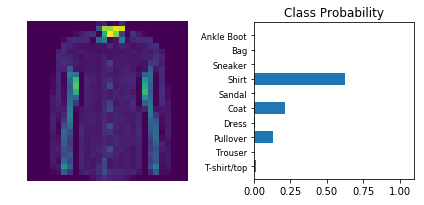

In [7]:
# Test out the network through inference
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D Tensor
img = img.view(1, 784)

with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and the probability
helper.view_classify(img, ps, version='Fashion')